<a href="https://colab.research.google.com/github/JericCantos/RetailDemandAnalysis/blob/main/notebooks/Guayas_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Continuing from the filtered data, we try to train a prediction model using XGBoost to see if it will perform better than the naive benchmarks / linear regression.

# EVALUATION: Baseline vs. Tuned XGBoost

| Metric | Baseline | Tuned |
| ------ | -------- | ----- |
| MAE | 0.80 | 0.78 |
| Bias | 0.03 | 0.05 |
| MAD | 0.84 | 0.84 |
| rMAD | 0.96 | 0.93 |
| MAPE | 90.62 | 89.42 |
| RMSE | 3.82 | 3.69 |

**MAE**: Both models are off by less than one unit on average, which makes the predictions more or less follow the peaks and troughs when taken as a whole. But when looking at specific store-item combinations, the model seems to be following the mean more closely. The tuned model performs slightly better.

**Bias**: Both models tend to over-forecast a little.

**MAPE**: The numbers appear inflated, most likely because of the prevalence of days with 0 sales. MAPE suffers in these circumstances.

**RMSE**: Tuned model performs better than Baseline. Given that the RMSE is roughly 5x MAE, it means the model is not very good at handling some large spikes. This is quite apparent when we look at the per-store-item combination plots.


## Conclusion

Hyperparameter tuning resulted in some modest gains. It is slightly better at tracking the mean, and is less prone to dramatic misses.

# ML Flow

In [ ]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.1/329.1 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.4/718.4 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72

In [ ]:
import mlflow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the MLflow storage path in Google Drive
mlflow_storage_path = "/content/drive/MyDrive/Masterschool_Time_Series/mlflow_results"

# Set MLflow to log to the Google Drive directory
mlflow.set_tracking_uri(f"file:{mlflow_storage_path}")

In [ ]:
# Set up experiment name
mlflow.set_experiment("Guayas_XGBoost_Variants")   # creates it once, reuses it next time

<Experiment: artifact_location='file:///content/drive/MyDrive/Masterschool_Time_Series/mlflow_results/735047345586653469', creation_time=1758900301578, experiment_id='735047345586653469', last_update_time=1758900301578, lifecycle_stage='active', name='Guayas_XGBoost_Variants', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [ ]:
!pip install pyngrok --quiet

In [ ]:
from pyngrok import ngrok, conf
import getpass
import subprocess

In [ ]:
# Launch MLflow UI on port 5000
subprocess.Popen(["mlflow", "ui", "--backend-store-uri", mlflow_storage_path])

<Popen: returncode: None args: ['mlflow', 'ui', '--backend-store-uri', '/con...>

In [ ]:
print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken")
auth_token = getpass.getpass()
conf.get_default().auth_token = auth_token
port=5000
public_url = ngrok.connect(port).public_url
print(f' * ngrok tunnel (ULR for MLFLow UI) \"{public_url}\" ')

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken
··········
 * ngrok tunnel (ULR for MLFLow UI) "https://nondiscoverable-rolanda-fancifully.ngrok-free.dev" 


# Reload Prepared Data

In [4]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.1 MB/s eta 0:00:00


In [5]:
import pandas as pd
import requests
import io
import numpy as np
import matplotlib.pyplot as plt


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import clone
from category_encoders import TargetEncoder, CatBoostEncoder


from xgboost import XGBRegressor

In [6]:
# Build the direct download URL from a file ID
def make_drive_url(file_id):
    return f"https://drive.google.com/uc?id={file_id}"

# Helper function to load a CSV from a direct URL
def load_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()  # Raises an error if the request fails
    return pd.read_csv(io.StringIO(response.text))

# Dictionary of file IDs for clarity
file_ids = {
    "holiday_events": "1RMjSuqHXHTwAw_PGD5XVjhA3agaAGHDH",
    "items": "1ogMRixVhNY6XOJtIRtkRllyOyzw1nqya",
    "oil": "1Q59vk2v4WQ-Rpc9t2nqHcsZM3QWGFje_",
    "stores": "1Ei0MUXmNhmOcmrlPad8oklnFEDM95cDi",
    "train": "1otcA0OoYn1QnG-hU-zKA-QfFsJ7g4HUX",
    "transactions": "1PW5LnAEAiL43fI5CRDn_h6pgDG5rtBW_"
}

# Load each CSV using the helper functions
df_holiday_events = load_csv_from_url(make_drive_url(file_ids["holiday_events"]))
df_items          = load_csv_from_url(make_drive_url(file_ids["items"]))
df_oil            = load_csv_from_url(make_drive_url(file_ids["oil"]))
df_stores         = load_csv_from_url(make_drive_url(file_ids["stores"]))
df_transactions   = load_csv_from_url(make_drive_url(file_ids["transactions"]))


## Load pickled dataset

In [7]:
import gdown

In [8]:
file_id = file_ids["train"]
url = make_drive_url(file_id)

# Download the file locally
output_path = "train.pkl"
gdown.download(url, output_path, quiet=False)

# Load it
df_train = pd.read_pickle(output_path)


Downloading...
From (original): https://drive.google.com/uc?id=1otcA0OoYn1QnG-hU-zKA-QfFsJ7g4HUX
From (redirected): https://drive.google.com/uc?id=1otcA0OoYn1QnG-hU-zKA-QfFsJ7g4HUX&confirm=t&uuid=db5a0870-7565-4857-a120-c8025e2bbc99
To: /content/train.pkl
100%|██████████| 2.05G/2.05G [00:25<00:00, 80.5MB/s]


In [9]:
df_train.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,is_outlier,unit_sales_capped,is_holiday,family,class,perishable,city,type,state,unit_sales_7d_avg,year,month,day,day_of_week
0,2013-01-17,622071,24,96995,2.0,False,False,2.0,False,GROCERY I,1093,False,Guayaquil,D,Guayas,2.000000,2013,1,17,3
1,2013-01-18,0,24,96995,0.0,False,False,0.0,False,GROCERY I,1093,False,Guayaquil,D,Guayas,1.000000,2013,1,18,4
2,2013-01-19,0,24,96995,0.0,False,False,0.0,False,GROCERY I,1093,False,Guayaquil,D,Guayas,0.666667,2013,1,19,5
3,2013-01-20,0,24,96995,0.0,False,False,0.0,False,GROCERY I,1093,False,Guayaquil,D,Guayas,0.500000,2013,1,20,6
4,2013-01-21,0,24,96995,0.0,False,False,0.0,False,GROCERY I,1093,False,Guayaquil,D,Guayas,0.400000,2013,1,21,0


In [10]:
df_train.shape

(22272053, 20)

## Verify data is correct

Check that df_train contains only records from Guayas, and only has products from the top 3 families (`GROCERY I`, `BEVERAGES`, `CLEANING`)

In [11]:
print(df_train['family'].unique())
print(df_train['state'].unique())
print(df_train['city'].unique())

store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()
print("Stores NOT from Guayas:"
  ,len(df_train[~df_train['store_nbr'].isin(store_ids)])
)

['GROCERY I' 'CLEANING' 'BEVERAGES']
['Guayas']
['Guayaquil' 'Daule' 'Libertad' 'Playas']
Stores NOT from Guayas: 0


## Filter for Jan 1 - Mar 31, 2014

In [12]:
df_train_backup = df_train.copy()

In [13]:
print ("Min date:", df_train['date'].min())
print ("Max date:", df_train['date'].max())
print ("Dataset Size:", len(df_train))

Min date: 2013-01-02 00:00:00
Max date: 2017-08-15 00:00:00
Dataset Size: 22272053


In [14]:
df_train = (
    df_train[(df_train['date'] >= '2014-01-01')
             & (df_train['date'] <= '2014-03-31')]
)
print ("Min date:", df_train['date'].min())
print ("Max date:", df_train['date'].max())
print ("Dataset Size:", len(df_train))

Min date: 2014-01-01 00:00:00
Max date: 2014-03-31 00:00:00
Dataset Size: 967396


In [15]:
print (len(df_train['store_nbr'].unique()))
print (len(df_train['item_nbr'].unique()))

10
1446


# Feature Engineering

## Lags

From the PACF done during data prep, the entire first week prior to date was significant. In fact, we saw significant spikes up until day 28. It is impractical to do a PACF and create specialized lags for each of the store (10) - item (1,446) combinations, but at least the PACF and domain knowledge from retail sugggest the following to be quite useful:

- Lag 1: Yesterday
- Lags 7, 14, 21, 28: Same day up to four weeks ago.

Lags beyond these would be impractical given that we've already filtered our dataset down to a three-month period.

During data prep, I had identified records with `unit_sales` considered to be outliers for their particular store-item combination (Z_score > 5). I had implemented a column called `unit_sales_capped` which would reflect the value of unit sales to have a Z_score = 5 exactly for these outliers. I will use this column instead base `unit_sales` to determine the lag features.

It should be noted that creating these lags would produce null columns, but XGBoost should be able to deal with them without us needing to drop them.

In [16]:
df_train[df_train['is_outlier']==True].head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,is_outlier,unit_sales_capped,is_holiday,family,class,perishable,city,type,state,unit_sales_7d_avg,year,month,day,day_of_week
2683,2014-01-10,16882336,36,96995,2.0,False,True,1.883143,False,GROCERY I,1093,False,Libertad,E,Guayas,0.285714,2014,1,10,4
11642,2014-01-25,17844076,30,103501,8.0,False,True,5.558201,False,CLEANING,3008,False,Guayaquil,C,Guayas,1.142857,2014,1,25,5
13319,2014-01-30,18164649,32,103501,5.0,False,True,3.531021,False,CLEANING,3008,False,Guayaquil,C,Guayas,1.000000,2014,1,30,3
14949,2014-01-08,16755588,34,103501,5.0,False,True,4.718909,False,CLEANING,3008,False,Guayaquil,B,Guayas,0.714286,2014,1,8,2
23045,2014-01-07,16685974,27,103520,4.0,False,True,2.162184,False,GROCERY I,1028,False,Daule,D,Guayas,0.571429,2014,1,7,1


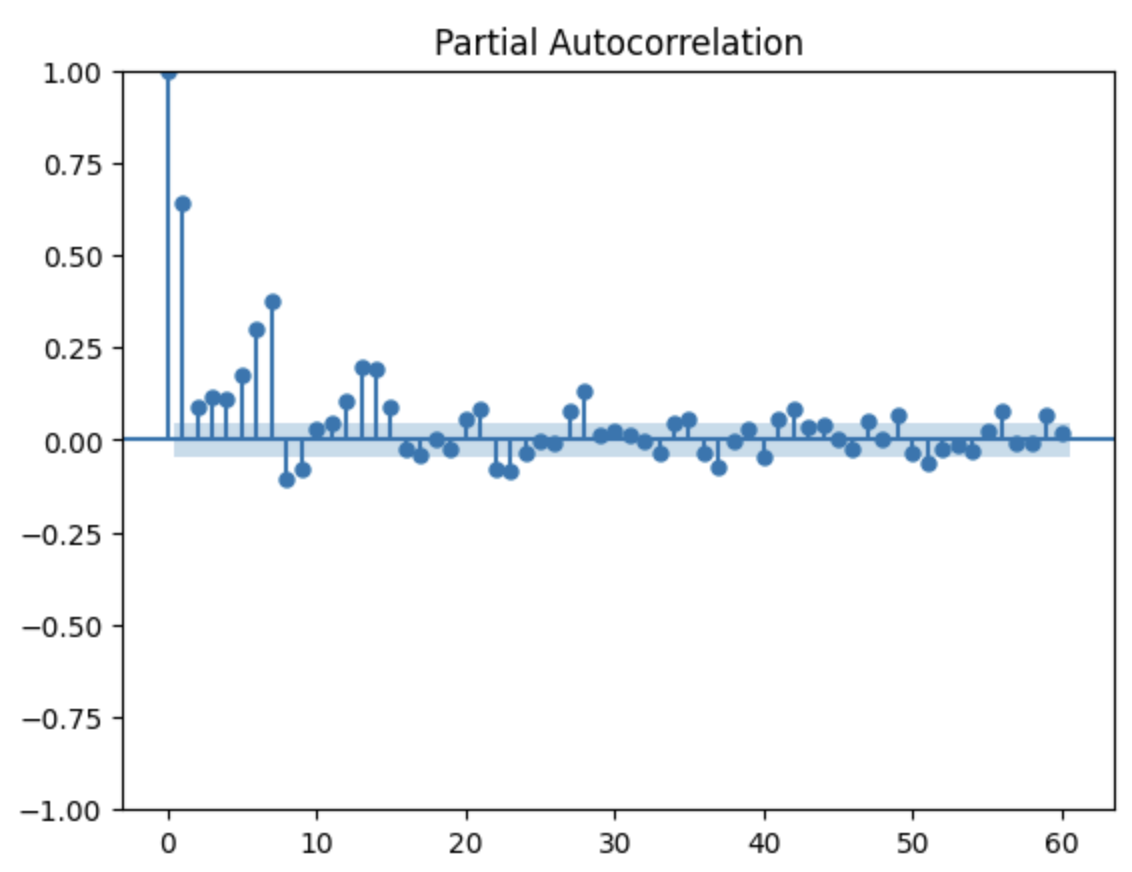

In [17]:
df_train['lag_1'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales_capped'].shift(1)
df_train['lag_7'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales_capped'].shift(7)
df_train['lag_14'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales_capped'].shift(14)
df_train['lag_21'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales_capped'].shift(21)
df_train['lag_28'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales_capped'].shift(28)
df_train['is_weekend'] = df_train['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# bad predictions on a per store item basis
# adding lags 2-6 to see if it would make it better
df_train['lag_2'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales_capped'].shift(2)
df_train['lag_3'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales_capped'].shift(3)
df_train['lag_4'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales_capped'].shift(4)
df_train['lag_5'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales_capped'].shift(5)
df_train['lag_6'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales_capped'].shift(6)

# add a store_item composite for future target encoding via CatBoostEncoder
# to hopefully get better at individual store-item predictions

df_train['store_item'] = (df_train['store_nbr'].astype(str)
                          + '_' + df_train['item_nbr'].astype(str))


## Rolling Statistics

The dataset shows a clear weekly seasonality, so a rolling window of 7 days seems most reasonable.

Capturing mean and standard deviation may help XGBoost learn weekly trend and variability respectively.

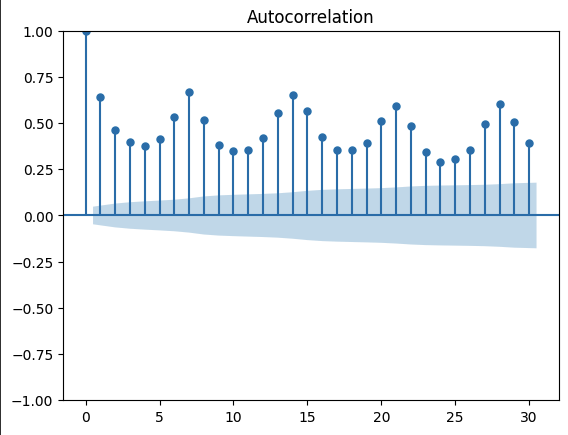

In [18]:
# drop the original computation, it was not shifted. also for consistency
df_train.drop(['unit_sales_7d_avg'], axis=1, inplace=True)

In [19]:
df_train['unit_sales_rolling_avg_7'] = (
    df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales']
      .shift(1)
      .rolling(window=7)
      .mean()
)

df_train['unit_sales_rolling_std_7'] = (
    df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales']
      .shift(1)
      .rolling(window=7)
      .std()
)

## Store- and Item-level data

From data prep, we already extracted item (family, class,  and perishable) as well as store ('city', 'type', 'state') data. State was captured only for ease of verification i.e. easier to know all rows were from Guayas. It should not be fed to the model.

In [20]:
df_train.drop(['state'], axis=1, inplace=True)

## Save Feature-Engineered Dataframe

In [21]:
save_path = "/content/drive/MyDrive/Masterschool_Time_Series/df_train_with_features.pkl"


df_train.to_pickle(save_path)
print(f"Saved to: {save_path}")

Saved to: /content/drive/MyDrive/Masterschool_Time_Series/df_train_with_features.pkl


# Train Test Split

Use Jan to Feb 2014 as training data, and March 2014 as test

In [ ]:
date_cutoff = '2014-03-01'
X_train = df_train[df_train['date'] < date_cutoff]
X_test = df_train[df_train['date'] >= date_cutoff]

y_train = X_train['unit_sales']
y_test = X_test['unit_sales']

X_train.drop(['unit_sales', 'unit_sales_capped', 'id', 'is_outlier'],
             axis=1, inplace=True)
X_test.drop(['unit_sales', 'unit_sales_capped', 'id', 'is_outlier'],
            axis=1, inplace=True)

/tmp/ipython-input-2277934212.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(['unit_sales', 'unit_sales_capped', 'id', 'is_outlier'],
/tmp/ipython-input-2277934212.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(['unit_sales', 'unit_sales_capped', 'id', 'is_outlier'],


In [ ]:
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(624923, 28) (624923,)
(342473, 28) (342473,)


In [ ]:
X_train.columns

Index(['date', 'store_nbr', 'item_nbr', 'onpromotion', 'is_holiday', 'family',
       'class', 'perishable', 'city', 'type', 'year', 'month', 'day',
       'day_of_week', 'lag_1', 'lag_7', 'lag_14', 'lag_21', 'lag_28',
       'is_weekend', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'store_item',
       'unit_sales_rolling_avg_7', 'unit_sales_rolling_std_7'],
      dtype='object')

In [ ]:
X_train.head()

,date,store_nbr,item_nbr,onpromotion,is_holiday,family,class,perishable,city,type,...,lag_28,is_weekend,lag_2,lag_3,lag_4,lag_5,lag_6,store_item,unit_sales_rolling_avg_7,unit_sales_rolling_std_7
349,2014-01-01,24,96995,False,True,GROCERY I,1093,False,Guayaquil,D,...,NaN,0,NaN,NaN,NaN,NaN,NaN,24_96995,NaN,NaN
350,2014-01-02,24,96995,False,False,GROCERY I,1093,False,Guayaquil,D,...,NaN,0,NaN,NaN,NaN,NaN,NaN,24_96995,NaN,NaN
351,2014-01-03,24,96995,False,False,GROCERY I,1093,False,Guayaquil,D,...,NaN,0,0.0,NaN,NaN,NaN,NaN,24_96995,NaN,NaN
352,2014-01-04,24,96995,False,False,GROCERY I,1093,False,Guayaquil,D,...,NaN,1,0.0,0.0,NaN,NaN,NaN,24_96995,NaN,NaN
353,2014-01-05,24,96995,False,False,GROCERY I,1093,False,Guayaquil,D,...,NaN,1,0.0,0.0,0.0,NaN,NaN,24_96995,NaN,NaN


# Encoding Pipeline Helper Functions

In [ ]:
def transform_cyclical_features(X):
  # transform month day into cyclical inputs so that the model learns
  # December is close to Janury, or Sunday is close to Monday
  X['month_sin'] = np.sin(2 * np.pi * X['month']/12)
  X['month_cos'] = np.cos(2 * np.pi * X['month']/12)
  X['dow_sin'] = np.sin(2 * np.pi * X['day_of_week']/7)
  X['dow_cos'] = np.cos(2 * np.pi * X['day_of_week']/7)
  return X

cyclical_transformer = FunctionTransformer(transform_cyclical_features, validate=False)

In [ ]:
def create_xgb_pipeline (bool_cols, num_cols, one_hot_cols,
                         target_cols, cyclical_cols):

  preprocessor = ColumnTransformer(transformers=[
    ('bool', OrdinalEncoder(dtype=int), bool_cols),
    ('num', 'passthrough', num_cols),  # tree-based model doesn't need scaling
    ('one_hot', OneHotEncoder(handle_unknown='ignore'), one_hot_cols),
    ('target', CatBoostEncoder(cols=target_cols, random_state=42), target_cols),
    ('cyclical', cyclical_transformer, cyclical_cols)
  ], remainder='drop')

  pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', XGBRegressor(random_state=42, objective='reg:squarederror'))
  ])

  return pipeline

# Model Evaluation Helper Function

In [ ]:
import numpy as np

def forecast_metrics(y_true, y_pred):
    """
    Compute a common set of forecast-error statistics.

    Parameters
    ----------
    y_true : 1-D array-like
        Actual (ground-truth) values.
    y_pred : 1-D array-like
        Forecasted values.

    Returns
    -------
    dict
        Keys: 'MAE', 'Bias', 'MAD', 'rMAD', 'MAPE', 'RMSE'
    """
    y_true = np.asarray(y_true, dtype=float).flatten()
    y_pred = np.asarray(y_pred, dtype=float).flatten()

    # basic errors
    errors       = y_true - y_pred
    abs_errors   = np.abs(errors)
    pct_errors   = abs_errors / np.where(y_true == 0, np.nan, y_true)   # avoid ÷0

    # core statistics
    mae   = abs_errors.mean()
    bias  = errors.mean()
    rmse  = np.sqrt((errors ** 2).mean())

    # MAD of the ACTUAL series (dispersion of demand itself)
    mad   = np.abs(y_true - y_true.mean()).mean()

    # Relative MAD = MAE divided by MAD  (how big the forecast error is vs. “typical” variation)
    rmad  = mae / mad if mad else np.nan

    # Mean Absolute Percentage Error
    mape  = np.nanmean(pct_errors) * 100   # expressed in %

    metrics = {
        "MAE" : mae,
        "Bias": bias,
        "MAD" : mad,
        "rMAD": rmad,
        "MAPE": mape,
        "RMSE": rmse
    }

    for k, v in metrics.items():
      print(f"{k}: {v:,.2f}")

    return metrics


# ML Flow Helper Functions

In [ ]:
from xgboost.sklearn import XGBModel
# --- plot train, predicted, and actual unit-sales for the whole df
def save_aggregate_plot(X_train, X_test,
                        #X_train_date, X_test_date,
                        y_test, y_train, y_pred,
                        path,
                        title="Daily Aggregated Sales: Train + Test + Predicted"):


  # --- Training data ---
  train_df = pd.DataFrame({
      'date': X_train['date'].reset_index(drop=True),
      #'date': loc_X_train['date'].reset_index(drop=True),
      'actual': y_train.reset_index(drop=True)
  })
  train_daily = train_df.groupby('date').sum().reset_index()

  # --- Test data ---
  test_df = pd.DataFrame({
      'date': X_test['date'].reset_index(drop=True),
      #'date': loc_X_test['date'].reset_index(drop=True),
      'actual': y_test.reset_index(drop=True),
      'predicted': y_pred
  })
  test_daily = test_df.groupby('date').sum().reset_index()


  plt.figure(figsize=(15,5))

  # Training actuals
  plt.plot(train_daily['date'], train_daily['actual'], label='Train Actual', color='blue')

  # Test actuals
  plt.plot(test_daily['date'], test_daily['actual'], label='Test Actual', color='green')

  # Test predictions
  plt.plot(test_daily['date'], test_daily['predicted'], label='Test Predicted', color='orange')

  plt.xlabel('Date')
  plt.ylabel('Unit Sales')
  plt.title('Daily Aggregated Sales: Train + Test + Predicted')
  plt.legend()
  plt.savefig(path)
  plt.show()
  plt.close()


# ---- one-stop logger for a single candidate
def log_candidate(run_name, params, y_true, y_pred, fig_name, model=None,
                  nested=True):
  if nested:
    with mlflow.start_run(run_name=run_name, nested=True):
        mlflow.log_params(params)
        mlflow.log_metrics(forecast_metrics(y_true, y_pred))

        if model is None:
            return
        elif isinstance(model, Pipeline):
            # log the full preprocessing + model pipeline
            mlflow.sklearn.log_model(model, artifact_path="model")
        elif isinstance(model, XGBModel):
            # fallback: log just the bare XGB
            mlflow.xgboost.log_model(model, artifact_path="model")
        else:
            pass

  mlflow.log_params(params)
  mlflow.log_metrics(forecast_metrics(y_true, y_pred))

  if model is None:
      return
  elif isinstance(model, Pipeline):
      # log the full preprocessing + model pipeline
      mlflow.sklearn.log_model(model, artifact_path="model")
  elif isinstance(model, XGBModel):
      # fallback: log just the bare XGB
      mlflow.xgboost.log_model(model, artifact_path="model")
  else:
      pass


In [ ]:
def plot_daily_aggregated_store_item(X_train, y_train, X_test, y_test, y_pred,
                                     store, item, run_name, rolling_window=None):
    """
    Plots daily aggregated sales for a specific store-item combination.
    Includes training actuals, test actuals, and test predictions.
    Optionally applies a rolling average.

    Parameters:
    - X_train, X_test: feature DataFrames (must include 'date', 'store_nbr', 'item_nbr')
    - y_train, y_test: Series of actual unit_sales
    - y_pred: numpy array or Series of predicted unit_sales for X_test
    - store, item: store number and item number to plot
    - rolling_window: int, optional rolling window size to smooth the curves
    """

    # --- Filter store-item ---
    train_subset = X_train[(X_train['store_nbr']==store) & (X_train['item_nbr']==item)].copy()
    train_subset['actual'] = y_train.loc[train_subset.index]

    test_subset = X_test.copy()
    test_subset['actual'] = y_test.values
    test_subset['predicted'] = y_pred
    test_subset = test_subset[(test_subset['store_nbr']==store)
                  & (test_subset['item_nbr']==item)].copy()
    test_subset = test_subset.reset_index(drop=True)


    # --- Aggregate by day ---
    train_daily = train_subset.groupby('date')['actual'].sum().reset_index()
    test_daily = test_subset.groupby('date')[['actual','predicted']].sum().reset_index()

    # --- Optional rolling average ---
    if rolling_window is not None:
        train_daily['actual'] = train_daily['actual'].rolling(rolling_window).mean()
        test_daily['actual'] = test_daily['actual'].rolling(rolling_window).mean()
        test_daily['predicted'] = test_daily['predicted'].rolling(rolling_window).mean()

    # --- Plot ---
    plt.figure(figsize=(15,5))
    plt.plot(train_daily['date'], train_daily['actual'], label='Train Actual', color='blue')
    plt.plot(test_daily['date'], test_daily['actual'], label='Test Actual', color='green')
    plt.plot(test_daily['date'], test_daily['predicted'], label='Test Predicted', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Unit Sales')
    plt.title(f'Daily Aggregated Sales: Store {store}, Item {item}')
    plt.legend()
    plt.savefig(run_name)
    plt.show()
    plt.close()


In [ ]:
def plot_store_item_group(group, group_name,
                          X_train, y_train,
                          X_test, y_test, y_pred,
                          run_name,
                          rolling_window=None):
  for row in group.itertuples():
      store = row.store_nbr
      item = row.item_nbr
      fig_name = f"{run_name}_S:{store}_I:{item}"
      plot_daily_aggregated_store_item(X_train, y_train, X_test, y_test, y_pred,
                                  store, item, fig_name,
                                  rolling_window)
      mlflow.log_artifact(f"{fig_name}.png")

In [ ]:
def log_xgb_search_run(search, X_train, y_train, X_test, y_test,
                       #X_train_date, X_test_date,
                       pipeline, run_name):
    for i, p in enumerate(search.cv_results_["params"]):

        iteration_name = run_name + f'_{i}'

        # Re-train on the full training set (not just the CV fold) for a fair test evaluation
        model = clone(pipeline)
        model.set_params(**{f"xgb__{k}": v for k, v in p.items()})

        model.fit(X_train, y_train)

        # Predict on the held‑out test set
        y_pred = model.predict(X_test)

        # Log this single candidate as a NESTED run:
        #  - params: all hyperparameters + model_type
        #  - metrics: computed inside log_candidate()
        #  - artifact: forecast plot saved to xgb_rs_i.png
        log_candidate(
            run_name=iteration_name,                 # child run name
            params={"model_type": "XGB", **p},      # merge model tag + params
            y_true=y_test,
            y_pred=y_pred,
            fig_name=f"{iteration_name}.png",
            model = model
        )

        save_aggregate_plot(X_train, X_test, y_test, y_train, y_pred,
                    path=f"{iteration_name}_aggregate.png")

        mlflow.log_artifact(f"{iteration_name}_aggregate.png")



# Store-Item Combinations for Investigation

Top 10 store-item combinations in terms of number of days with non-zero sales

In [ ]:
df_train['positive_sales'] = df_train['unit_sales']>0

positive_counts = (
    df_train.groupby(['store_nbr', 'item_nbr'])
      ['positive_sales'].sum().reset_index()
)
top_most_sales_days = (
    positive_counts.sort_values(by='positive_sales', ascending=False).head(10)
)
print(top_most_sales_days)

       store_nbr  item_nbr  positive_sales
135           24    226857              18
3780          28    210798              17
8479          35   1066900              17
10737         51   1047685              17
5884          32    224081              16
6483          32   1114567              16
3401          27   1137146              16
7600          34   1146802              16
73            24    168927              16
10294         51    502230              16


# XGBoost Baseline

Run vanilla XGBoost with default parameters to see how well it performs.

In [ ]:
# Column groups
bool_cols = ['onpromotion', 'is_holiday', 'perishable', 'is_weekend']
num_cols = ['lag_1', 'lag_7', 'lag_14', 'lag_21', 'lag_28',
            'day', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
            'unit_sales_rolling_avg_7', 'unit_sales_rolling_std_7']

one_hot_cols = ['city', 'type', 'family', 'store_nbr']  # low-cardinality

target_cols = ['class', 'item_nbr', 'store_item']  # high-cardinality

cyclical_cols = ['month', 'day_of_week']

In [ ]:
pipeline = create_xgb_pipeline(bool_cols, num_cols, one_hot_cols,
                               target_cols, cyclical_cols)

In [ ]:
param_grid = {} # empty so it only uses default parameterss

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    # RMSE is typical for sales forecasting
    # negative beccause scikit learn tries to MAXIMIZE the scoring function
    # therefore multiplying by -1 will make big RMSE worse
    verbose=2,
    n_jobs=-1
)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('bool',
                                                                         OrdinalEncoder(dtype=<class 'int'>),
                                                                         ['onpromotion',
                                                                          'is_holiday',
                                                                          'perishable',
                                                                          'is_weekend']),
                                                                        ('num',
                                                                         'passthrough',
                                                                         ['lag_1',
                                                                          'lag_7',
                                                                          'lag_14',
                                                                          'lag_21',
                                                                          'lag_28',
                                                                          'day',
                                                                          'lag_2',
                                                                          'lag_3',
                                                                          'lag_...
                                                     interaction_constraints=None,
                                                     learning_rate=None,
                                                     max_bin=None,
                                                     max_cat_threshold=None,
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None, ...))]),
             n_jobs=-1, param_grid={}, scoring='neg_root_mean_squared_error',
             verbose=2)

In [ ]:
run_name = "XGB_vanilla"

In [ ]:
vanilla_best_model = grid_search.best_estimator_

2025/09/29 13:06:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MAE: 0.80
Bias: 0.03
MAD: 0.84
rMAD: 0.96
MAPE: 90.62
RMSE: 3.82


2025/09/29 13:06:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


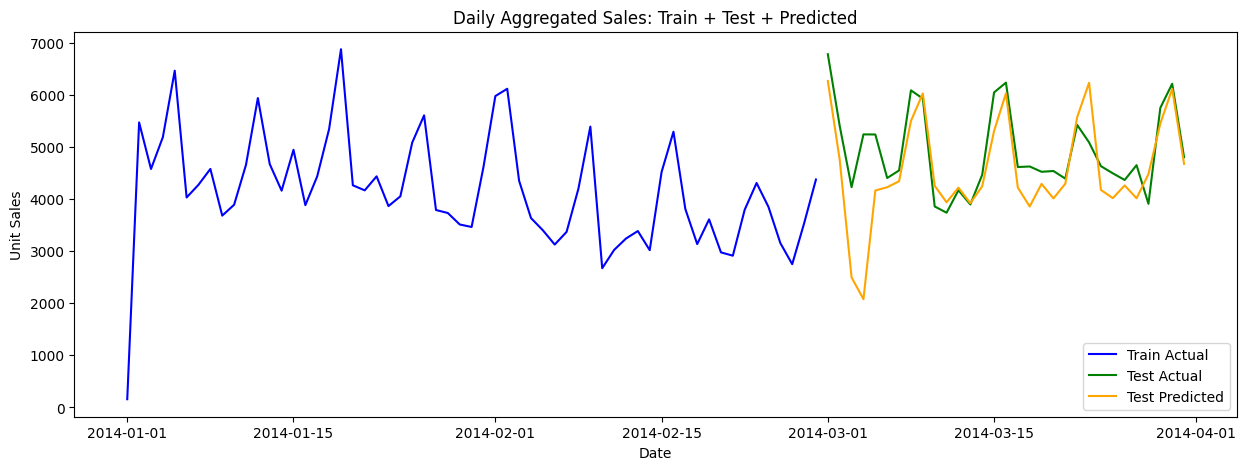

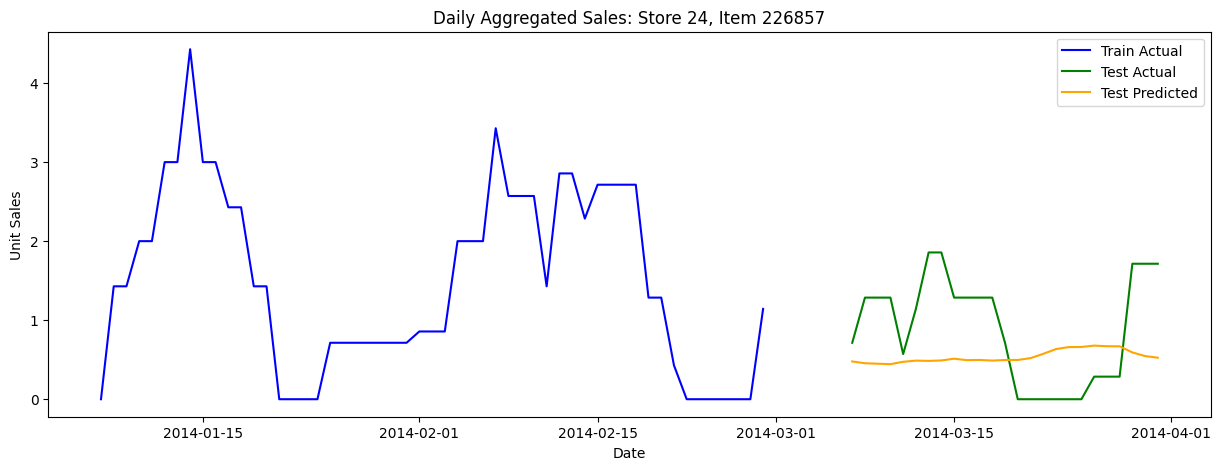

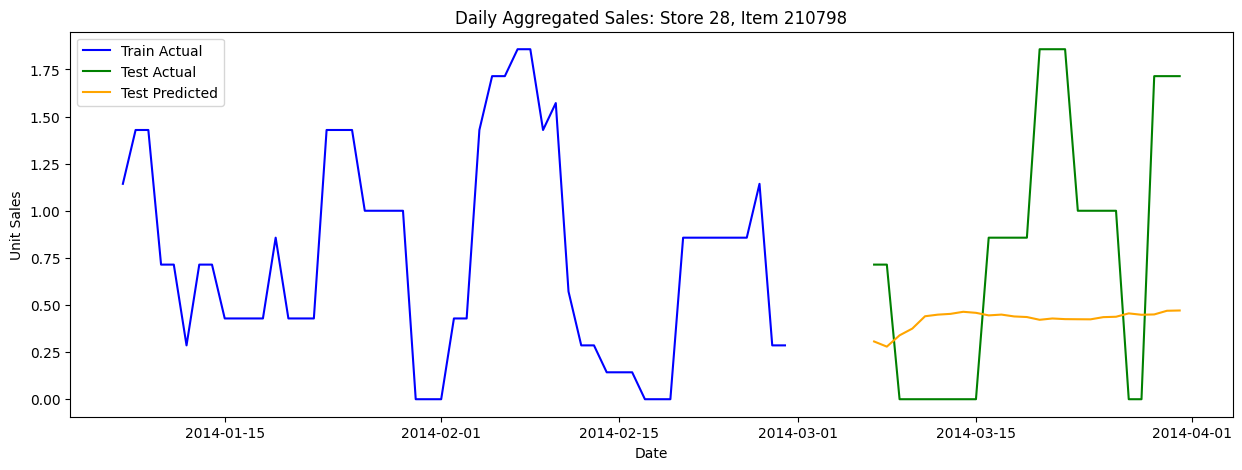

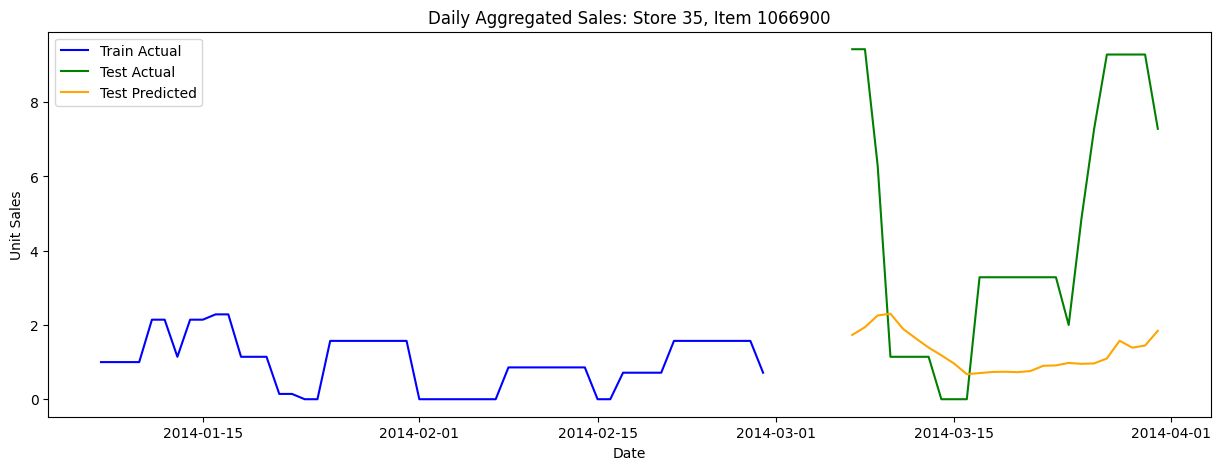

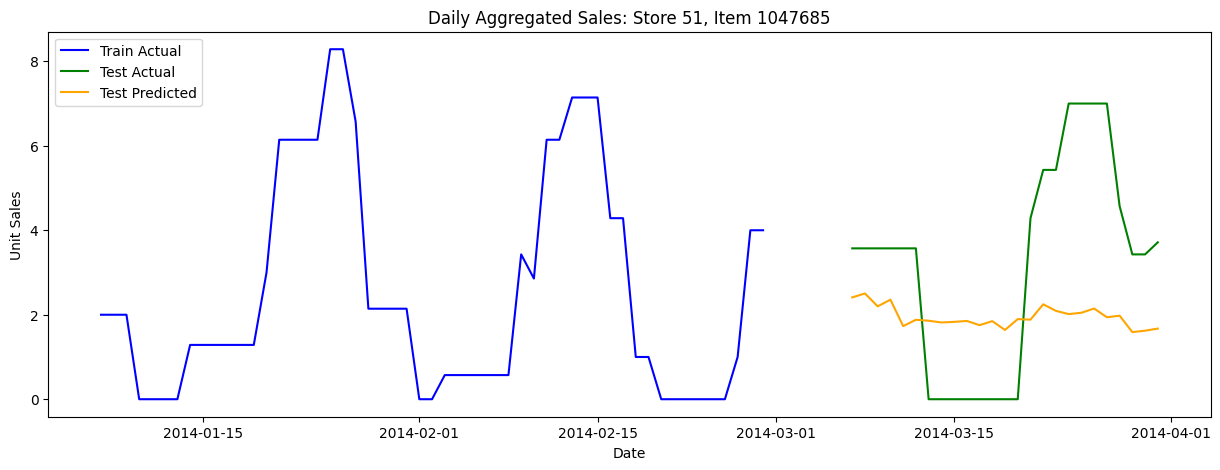

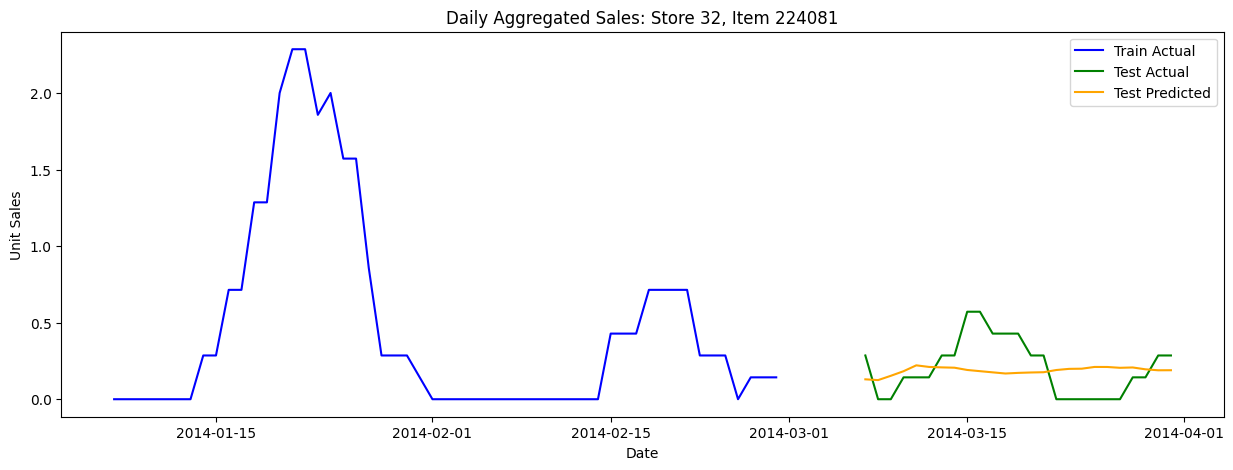

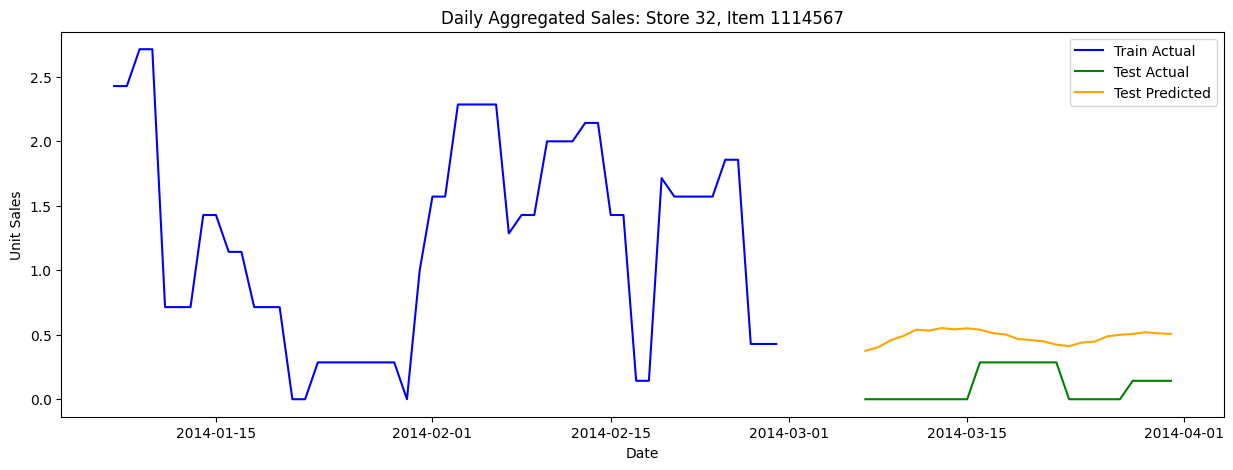

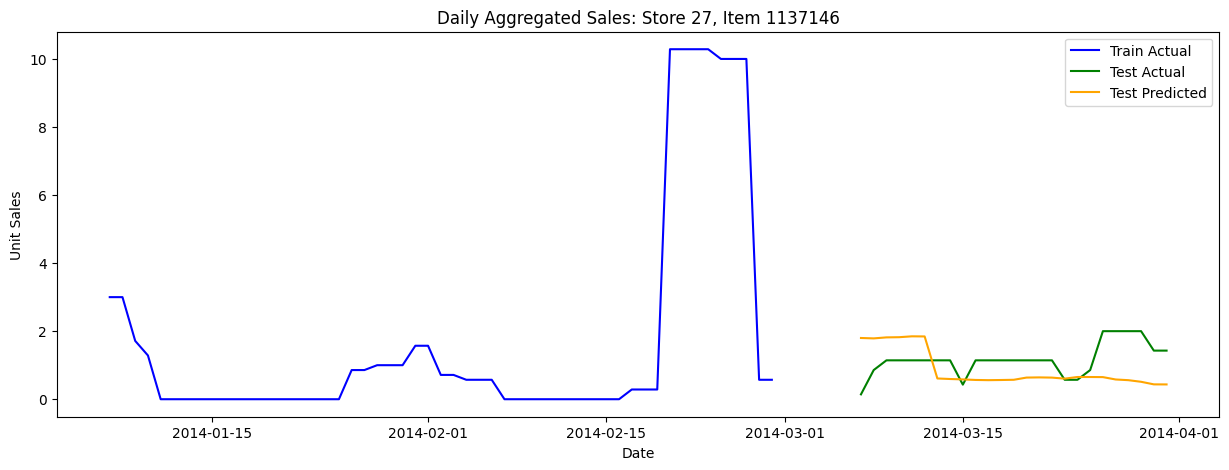

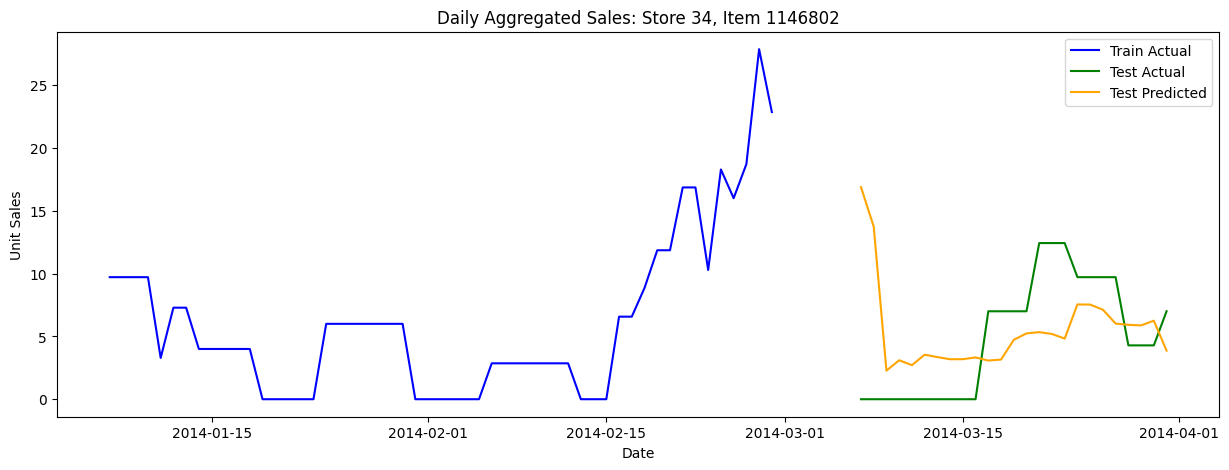

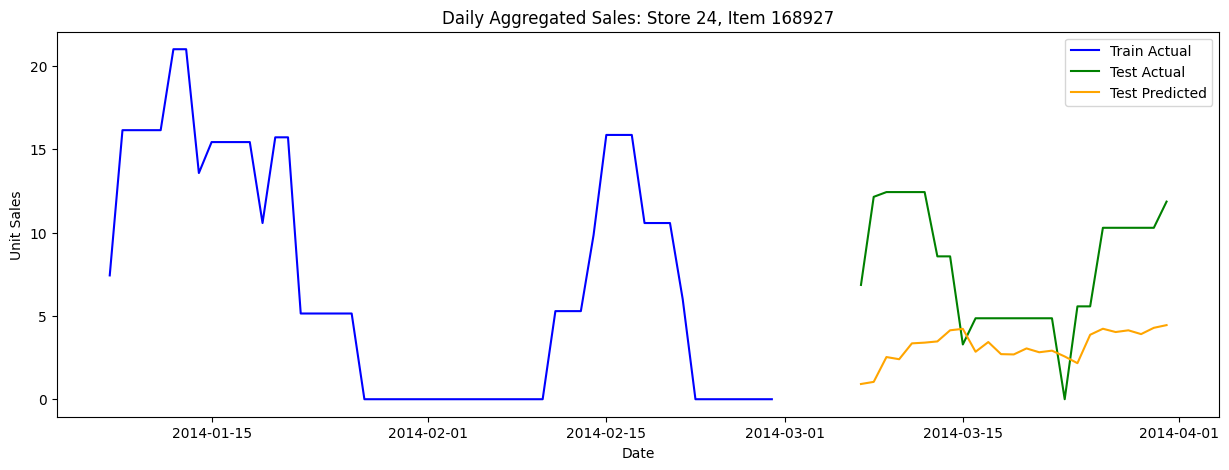

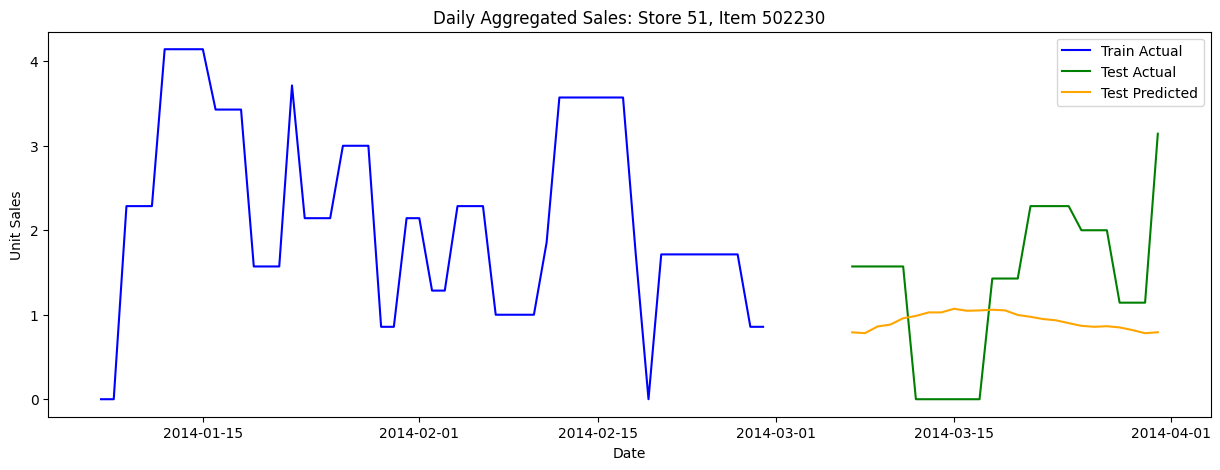

2025/09/29 13:06:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/29 13:06:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [ ]:
with mlflow.start_run(run_name=run_name):

  # Predict on the held‑out test set
  y_pred = vanilla_best_model.predict(X_test)
  p = grid_search.best_params_
  # Log this single candidate:
  #  - params: all hyperparameters + model_type
  #  - metrics: computed inside log_candidate()
  log_candidate(
      run_name=run_name,
      params={"model_type": "XGB", **p},      # merge model tag + params
      y_true=y_test,
      y_pred=y_pred,
      fig_name=f"{run_name}.png",
      model = vanilla_best_model,
      nested = False
  )

  save_aggregate_plot(X_train, X_test,
                      y_test, y_train, y_pred,
                      path=f"{run_name}_aggregate.png")

  mlflow.log_artifact(f"{run_name}_aggregate.png")

  plot_store_item_group(top_most_sales_days, 'Top_Combos_by_NonZero_Sales_Days',
                    X_train, y_train,
                    X_test, y_test, y_pred,
                    run_name, rolling_window=7)

  mlflow.sklearn.log_model(
      sk_model=vanilla_best_model,
      artifact_path="model"
  )

# Tuned XGBoost

Compare best estimator performance from randomized search to baseline model.

For readability, I will only log the best estimator in ML FLow

In [ ]:
# Column groups
bool_cols = ['onpromotion', 'is_holiday', 'perishable', 'is_weekend']
num_cols = ['lag_1', 'lag_7', 'lag_14', 'lag_21', 'lag_28',
            'day', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
            'unit_sales_rolling_avg_7', 'unit_sales_rolling_std_7']

one_hot_cols = ['city', 'type', 'family', 'store_nbr']  # low-cardinality

target_cols = ['class', 'item_nbr', 'store_item']  # high-cardinality

cyclical_cols = ['month', 'day_of_week']

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
param_grid = {
    'xgb__n_estimators': [100, 500],
    'xgb__max_depth': [5, 10],
    'xgb__learning_rate': [0.05, 0.1],
    'xgb__subsample': [0.7, 1.0],
    'xgb__colsample_bytree': [0.7, 1.0],
}

In [ ]:
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_iter=10,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

In [ ]:
random_search.fit(X_train, y_train)
print("Best parameters:", random_search.best_params_)
print("Best RMSE:", -random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'xgb__subsample': 0.7, 'xgb__n_estimators': 100, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.05, 'xgb__colsample_bytree': 0.7}
Best RMSE: 3.250610481863535


In [ ]:
random_xgb_best_model = random_search.best_estimator_

MAE: 0.78
Bias: 0.05
MAD: 0.84
rMAD: 0.93
MAPE: 89.42
RMSE: 3.69


2025/09/29 13:20:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/29 13:20:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


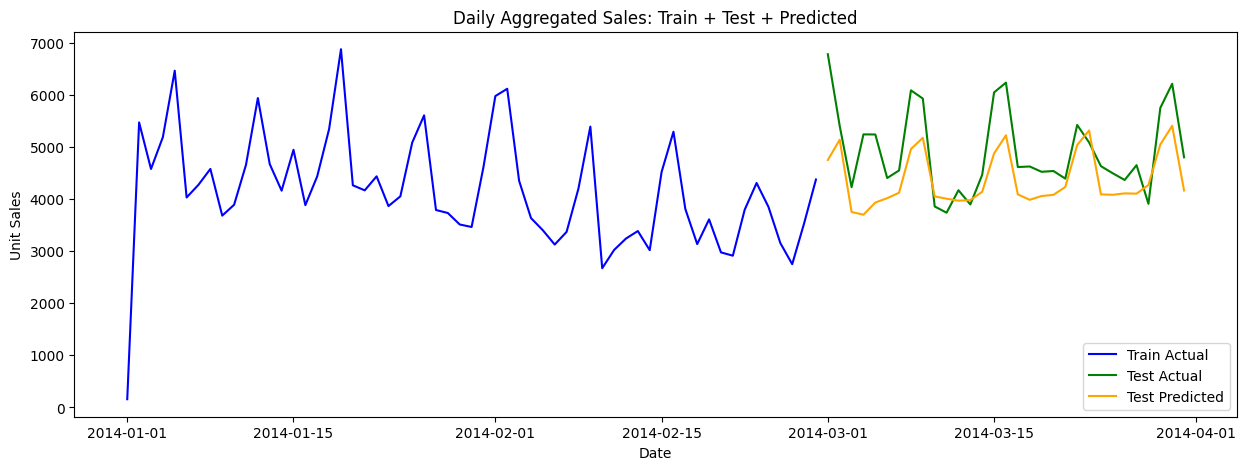

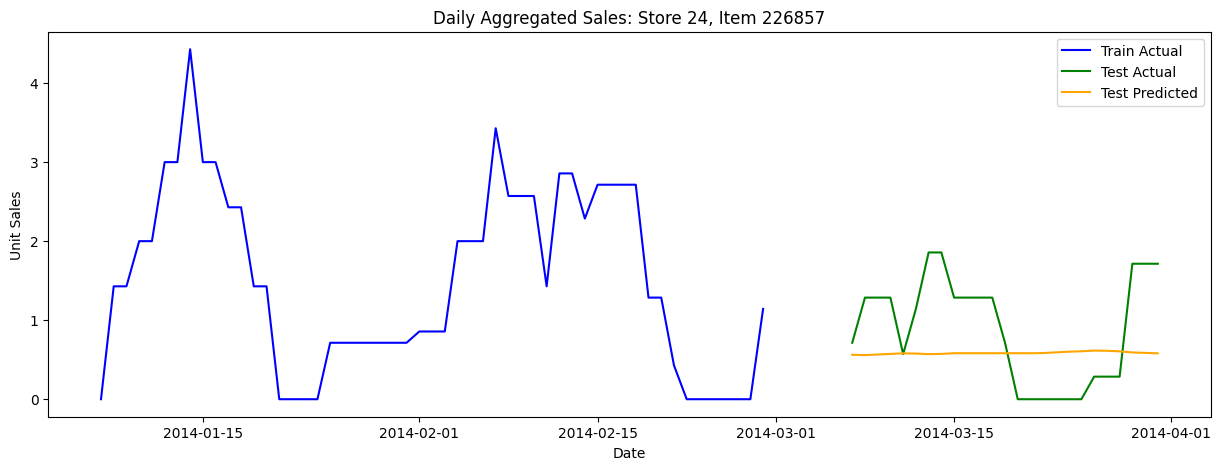

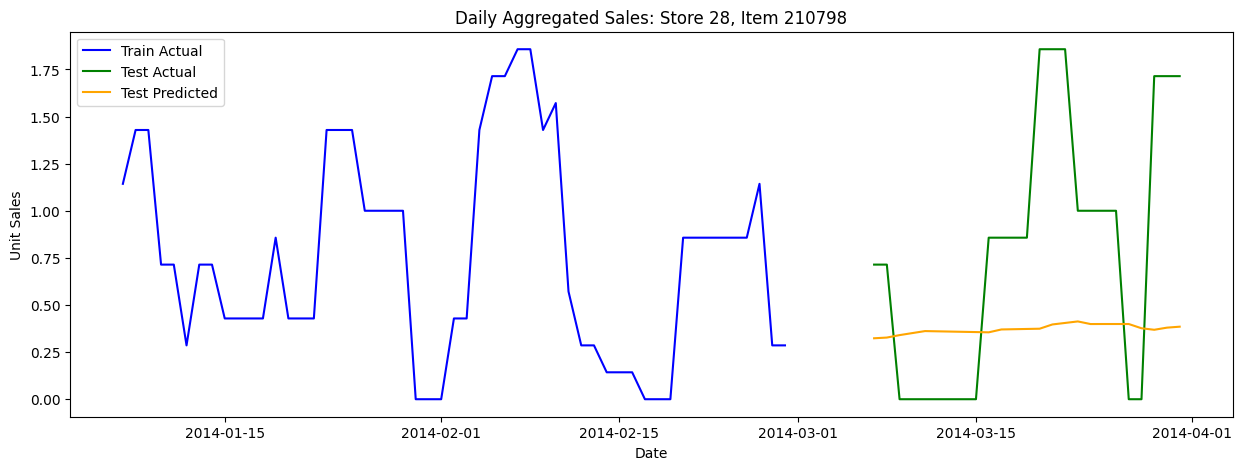

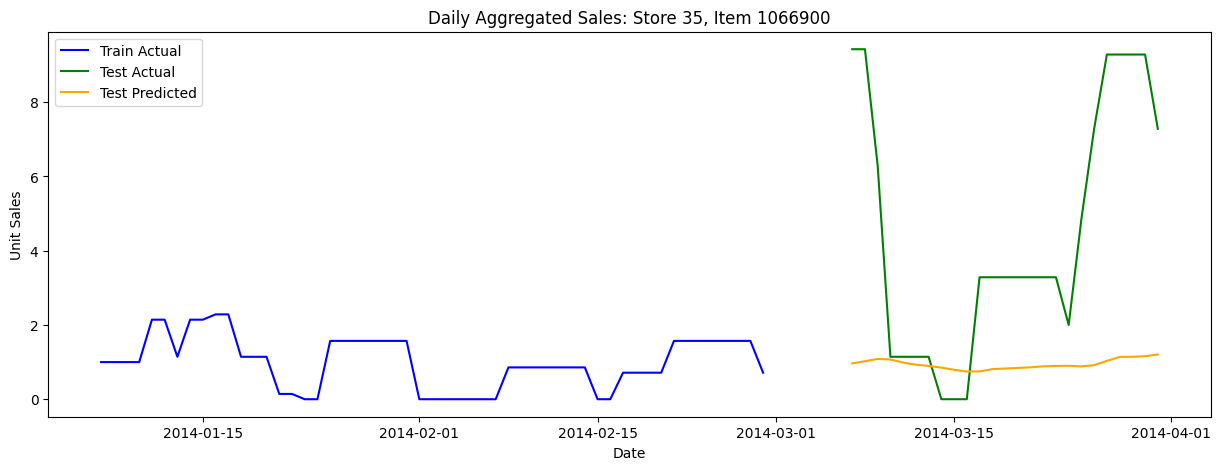

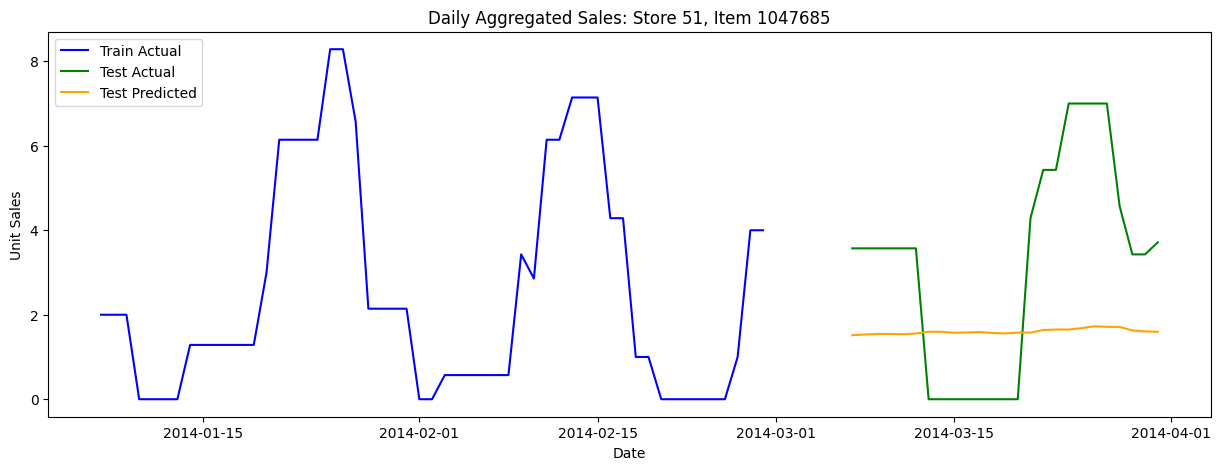

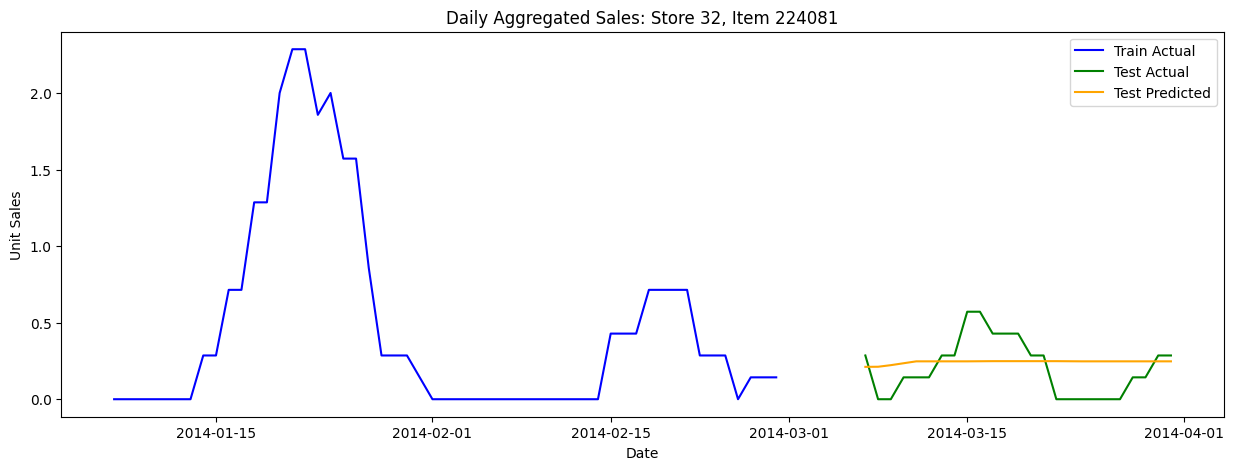

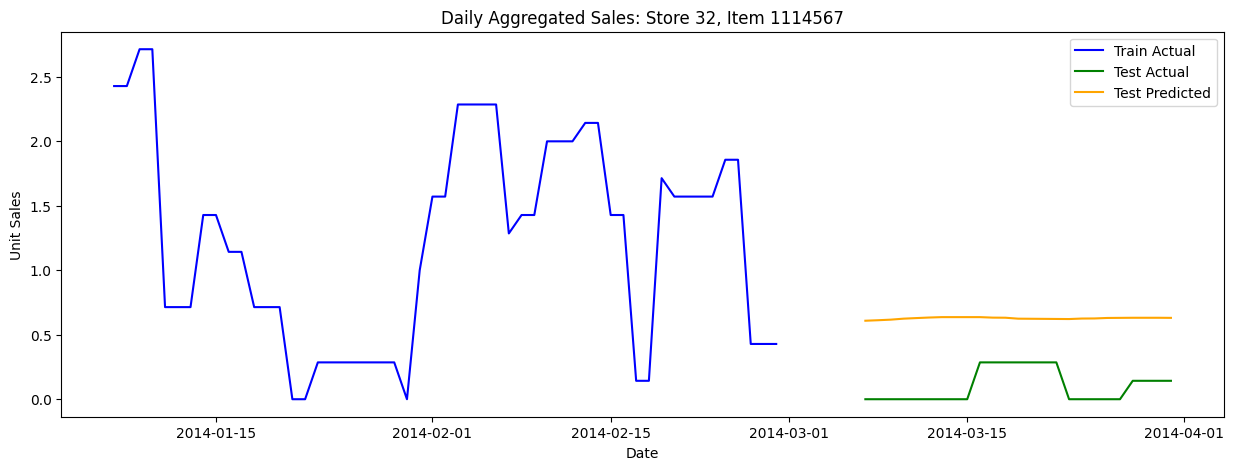

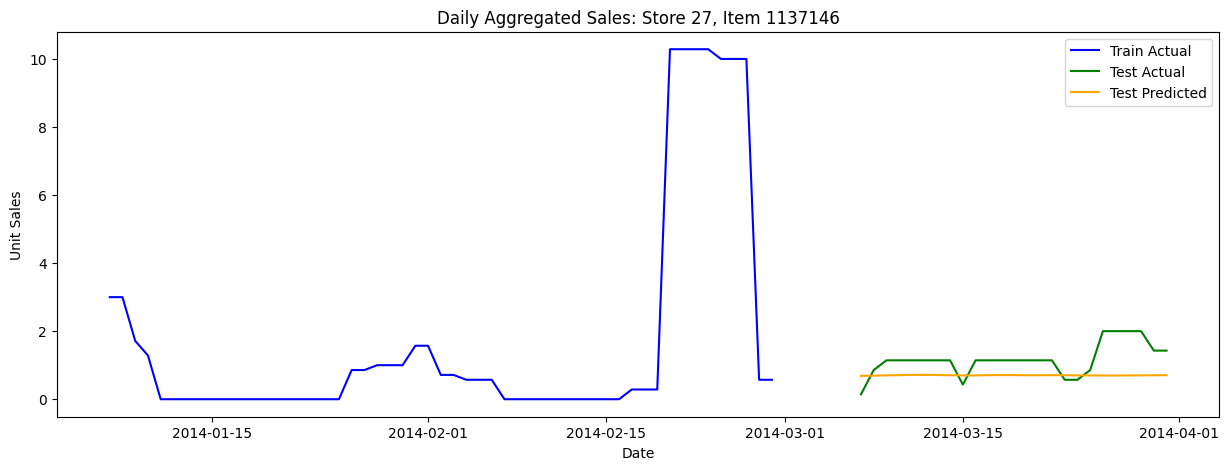

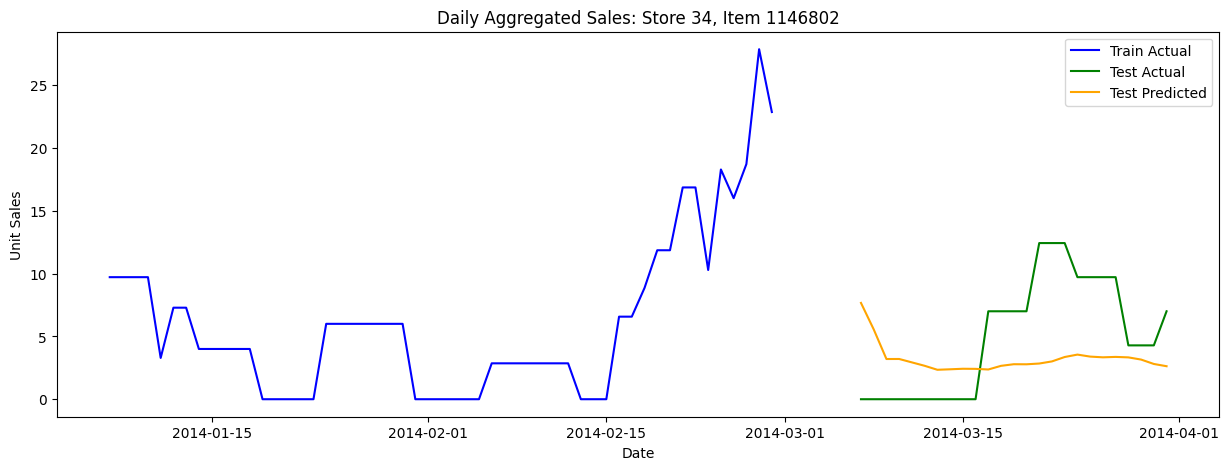

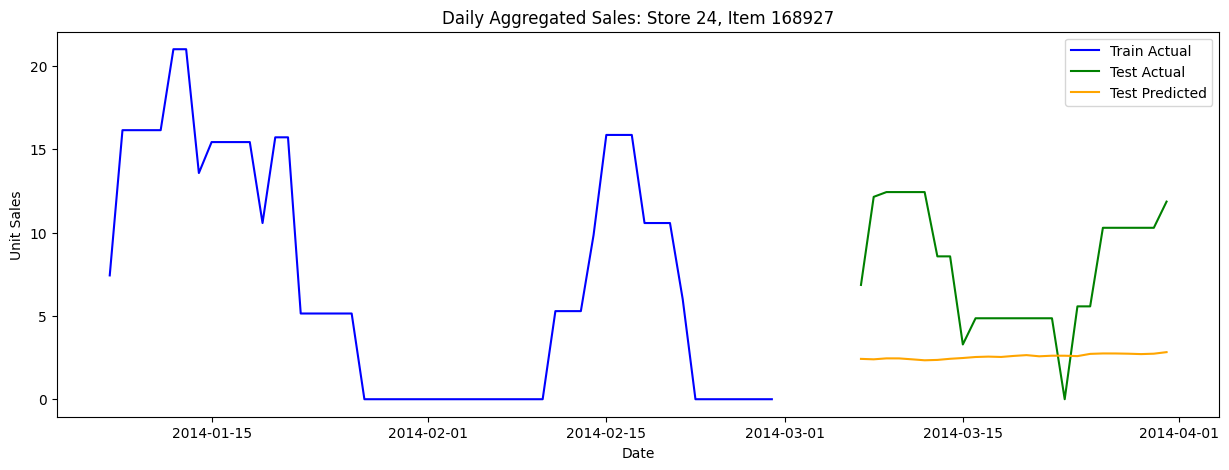

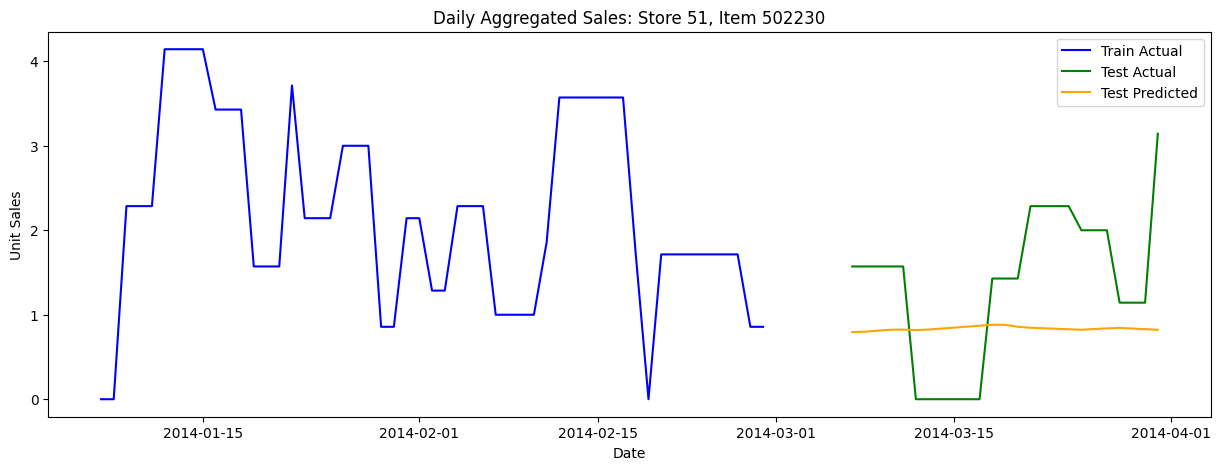

2025/09/29 13:20:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/29 13:20:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [ ]:
run_name = "XGB_random_search"
with mlflow.start_run(run_name=run_name):

  # Predict on the held‑out test set
  y_pred = random_xgb_best_model.predict(X_test)
  p = random_search.best_params_
  # Log this single candidate:
  #  - params: all hyperparameters + model_type
  #  - metrics: computed inside log_candidate()
  log_candidate(
      run_name=run_name,
      params={"model_type": "XGB", **p},      # merge model tag + params
      y_true=y_test,
      y_pred=y_pred,
      fig_name=f"{run_name}.png",
      model = random_xgb_best_model,
      nested = False
  )

  save_aggregate_plot(X_train, X_test,
                      y_test, y_train, y_pred,
                      path=f"{run_name}_aggregate.png")

  mlflow.log_artifact(f"{run_name}_aggregate.png")

  plot_store_item_group(top_most_sales_days, 'Top_Combos_by_NonZero_Sales_Days',
                        X_train, y_train,
                        X_test, y_test, y_pred,
                        run_name, rolling_window=7)

  mlflow.sklearn.log_model(
      sk_model=random_xgb_best_model,
      artifact_path="model"
  )

In [ ]:
!python --version

Python 3.12.11
